<a href="https://colab.research.google.com/github/Untick/IrisID_gr2/blob/Alexey-Tatarinov-folder/Alexey%20Tatarinov/Iris_Model_2_20_06_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Задача идентификации пациента по радужной оболочке глаза (Iris ID)**



**Постановка задачи**

Необходимо построить нейронную сеть и обучить ее, подав на нее изображения радужной оболочки правого и левого глаза 64 пациентов

**Описание данных**

Данные, используемые для идентификации пациента:
Цветные изображения переднего сегмента глаз в формате png. В качестве источника датасета задействованы 64
человека.
Задействованных людей можно использовать для тестирования
обученной сети.

**Гипотезы и эксперименты**

Для решения задачи проводились эксперименты с архитектурой нейронной сети:

1) Проверено около 15-20 различных архитектур методом ручного подбора оптимальных слоев для получения наибольшей точности (accuracy) на тестовых изображениях, а также перебраны гиперпараметры для каждой из данных архитектур.

2) Проверена и проанализирована точность моделей, построенных с помощью AutoML, а именно AutoKeras, на основе графиков функции потерь и точности.

3) Получены и проанализированы графики функции потерь и точности нейронной сети, в архитектуре которой использована предобученная модель.

**Выводы**

После проверки гипотез и проведения анализа графиков, полученных в результате экспериментов наилучшую точность показала нейронная сеть на основе предобученной модели ResNet50. В результате получена точность 100%.

## **Импорт библиотек и модулей**

In [ ]:
import gdown

import os

! pip install Augmentor
import Augmentor

import zipfile

import numpy as np

import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten,
                                     Dropout, BatchNormalization, Rescaling,
                                     GlobalAveragePooling2D, RandomFlip, Input,
                                     RandomRotation, RandomZoom, RandomContrast)

from tensorflow.keras.applications import VGG19, ResNet50, Xception

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import (ImageDataGenerator,
                                                 DirectoryIterator)

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import OneHotEncoder

from PIL import Image, ImageEnhance

import matplotlib.pyplot as plt

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Подготовка датасета**

### **Задание гиперпараметров**

In [ ]:
PATH          = '/content/drive/MyDrive/iris_ds'
PATH_AUG      = '/content/drive/MyDrive/Iris'
TRAIN_VAL_PATH_AUG = '/content/drive/MyDrive/Iris_train_val_aug'
TRAIN_VAL_PATH = '/content/drive/MyDrive/iris_ds_train_val'
TEST_PATH = '/content/drive/MyDrive/iris_ds_test'

VAL_SPLIT           = 0.2

IMG_WIDTH_2         = 80
IMG_HEIGHT_2        = 60
IMG_CHANNELS        = 3

ROTATION_RANGE      = 10
WIDTH_SHIFT_RANGE   = 0.1
HEIGHT_SHIFT_RANGE  = 0.1
ZOOM_RANGE          = 0.1
BRIGHTNESS_RANGE    = (0.5, 1.3)
HORIZONTAL_FLIP     = False

EPOCHS              = 20
BATCH_SIZE          = 24
OPTIMIZER_LEGACY    = tf.keras.optimizers.legacy.Adam(0.0001)
OPTIMIZER           = tf.keras.optimizers.Adam(0.0001)

### **Загрузка датасета**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Создание папок с изображениями**

In [ ]:
import os
import shutil

# Создание целевых папок, если они не существуют
os.makedirs(TEST_PATH, exist_ok=True)
os.makedirs(TRAIN_VAL_PATH, exist_ok=True)

# Получение списка подпапок в папке PATH
subfolders = [f for f in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, f))]

# Обработка каждой подпапки
for subfolder in subfolders:
    # Путь к исходной папке клиента
    client_folder = os.path.join(PATH, subfolder)

    # Путь к папке клиента в '/content/drive/MyDrive/iris_ds_test'
    target_client_folder_1 = os.path.join(TEST_PATH, subfolder)
    os.makedirs(target_client_folder_1, exist_ok=True)

    # Путь к папке клиента в '/content/drive/MyDrive/iris_ds_train_val'
    target_client_folder_2 = os.path.join(TRAIN_VAL_PATH, subfolder)
    os.makedirs(target_client_folder_2, exist_ok=True)

    # Получение списка файлов в папке клиента
    files = os.listdir(client_folder)

    # Копирование первого файла в '/content/drive/MyDrive/iris_ds_test'
    first_file = files[0]
    source_path = os.path.join(client_folder, first_file)
    target_path = os.path.join(target_client_folder_1, first_file)
    shutil.copyfile(source_path, target_path)

    # Копирование оставшихся пяти файлов в '/content/drive/MyDrive/iris_ds_train_val'
    remaining_files = files[1:]
    for file in remaining_files:
        source_path = os.path.join(client_folder, file)
        target_path = os.path.join(target_client_folder_2, file)
        shutil.copyfile(source_path, target_path)

### **Аугментация**

In [ ]:
for folder in os.listdir(TRAIN_VAL_PATH):
    if os.path.isdir(os.path.join(TRAIN_VAL_PATH, folder)):
        # Создаем генератор аугментации для каждой папки
        p = Augmentor.Pipeline(os.path.join(TRAIN_VAL_PATH, folder), output_directory=os.path.join(f'/content/drive/MyDrive/Iris_train_val_aug/{folder}'))
        # Добавляем операции аугментации
        # Вращение изображения
        p.rotate(probability=0.2, max_left_rotation=10, max_right_rotation=10)
        # увеличение
        #p.zoom(probability=0.2, min_factor=1.1, max_factor=1.2)
        # Обрезание изображения
        p.crop_random(probability=0.1, percentage_area=0.95)
        # Изменение яркости
        p.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.3)
        # Изменение контрасности
        p.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.3)
        # Применяем аугментацию
        p.sample(50)
print('Аугментация завершена')

### **Создание базы**

In [ ]:
CLASS_LIST = sorted(os.listdir(TRAIN_VAL_PATH_AUG))
CLASS_COUNT = len(CLASS_LIST)

print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 64, метки классов: ['client_1', 'client_10', 'client_11', 'client_12', 'client_13', 'client_14', 'client_15', 'client_16', 'client_17', 'client_18', 'client_19', 'client_2', 'client_20', 'client_21', 'client_22', 'client_23', 'client_24', 'client_25', 'client_26', 'client_27', 'client_28', 'client_29', 'client_3', 'client_30', 'client_31', 'client_32', 'client_33', 'client_34', 'client_35', 'client_36', 'client_37', 'client_38', 'client_39', 'client_4', 'client_40', 'client_41', 'client_42', 'client_43', 'client_44', 'client_45', 'client_46', 'client_47', 'client_48', 'client_49', 'client_5', 'client_50', 'client_51', 'client_52', 'client_53', 'client_54', 'client_55', 'client_56', 'client_57', 'client_58', 'client_59', 'client_6', 'client_60', 'client_61', 'client_62', 'client_63', 'client_64', 'client_7', 'client_8', 'client_9']


In [ ]:
data_files = []
data_labels = []

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = f'{TRAIN_VAL_PATH_AUG}/{class_name}'  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]
    data_labels += [class_label] * len(class_files)
    print(f'Размер класса {class_name} составляет {len(class_files)} снимков')

print('Общий размер базы для обучения:', len(data_labels))

Размер класса client_1 составляет 50 снимков
Размер класса client_10 составляет 50 снимков
Размер класса client_11 составляет 50 снимков
Размер класса client_12 составляет 50 снимков
Размер класса client_13 составляет 50 снимков
Размер класса client_14 составляет 50 снимков
Размер класса client_15 составляет 50 снимков
Размер класса client_16 составляет 50 снимков
Размер класса client_17 составляет 50 снимков
Размер класса client_18 составляет 50 снимков
Размер класса client_19 составляет 50 снимков
Размер класса client_2 составляет 50 снимков
Размер класса client_20 составляет 50 снимков
Размер класса client_21 составляет 50 снимков
Размер класса client_22 составляет 50 снимков
Размер класса client_23 составляет 50 снимков
Размер класса client_24 составляет 50 снимков
Размер класса client_25 составляет 50 снимков
Размер класса client_26 составляет 50 снимков
Размер класса client_27 составляет 50 снимков
Размер класса client_28 составляет 50 снимков
Размер класса client_29 составляет 5

In [ ]:
data_images = []

for file_name in data_files:
    img = Image.open(file_name).resize((IMG_WIDTH_2, IMG_HEIGHT_2))
    img_np = np.array(img)
    data_images.append(img_np)

x_data_small = np.array(data_images)
y_data = np.array(data_labels)

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data_small.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

В массив собрано 3200 фотографий следующей формы: (60, 80, 3)
Общий массив данных изображений следующей формы: (3200, 60, 80, 3)
Общий массив меток классов следующей формы: (3200,)


In [ ]:
CLASS_LIST_TEST = sorted(os.listdir(TEST_PATH))
CLASS_COUNT_TEST = len(CLASS_LIST_TEST)

print(f'Количество классов: {CLASS_COUNT_TEST}, метки классов: {CLASS_LIST_TEST}')

Количество классов: 64, метки классов: ['client_1', 'client_10', 'client_11', 'client_12', 'client_13', 'client_14', 'client_15', 'client_16', 'client_17', 'client_18', 'client_19', 'client_2', 'client_20', 'client_21', 'client_22', 'client_23', 'client_24', 'client_25', 'client_26', 'client_27', 'client_28', 'client_29', 'client_3', 'client_30', 'client_31', 'client_32', 'client_33', 'client_34', 'client_35', 'client_36', 'client_37', 'client_38', 'client_39', 'client_4', 'client_40', 'client_41', 'client_42', 'client_43', 'client_44', 'client_45', 'client_46', 'client_47', 'client_48', 'client_49', 'client_5', 'client_50', 'client_51', 'client_52', 'client_53', 'client_54', 'client_55', 'client_56', 'client_57', 'client_58', 'client_59', 'client_6', 'client_60', 'client_61', 'client_62', 'client_63', 'client_64', 'client_7', 'client_8', 'client_9']


In [ ]:
data_files_test = []
data_labels_test = []

for class_label_test in range(CLASS_COUNT_TEST):    # Для всех классов по порядку номеров (их меток)
    class_name_test = CLASS_LIST_TEST[class_label_test]  # Выборка имени класса из списка имен
    class_path_test = f'{TEST_PATH}/{class_name_test}'  # Формирование полного пути к папке с изображениями класса
    class_files_test = os.listdir(class_path_test)  # Получение списка имен файлов с изображениями текущего класса
    data_files_test += [f'{class_path_test}/{file_name}' for file_name in class_files_test]
    data_labels_test += [class_label_test] * len(class_files_test)
    print(f'Размер класса {class_name_test} составляет {len(class_files_test)} снимков')

print('Общий размер базы для проверки:', len(data_labels_test))

Размер класса client_1 составляет 1 снимков
Размер класса client_10 составляет 1 снимков
Размер класса client_11 составляет 1 снимков
Размер класса client_12 составляет 1 снимков
Размер класса client_13 составляет 1 снимков
Размер класса client_14 составляет 1 снимков
Размер класса client_15 составляет 1 снимков
Размер класса client_16 составляет 1 снимков
Размер класса client_17 составляет 1 снимков
Размер класса client_18 составляет 1 снимков
Размер класса client_19 составляет 1 снимков
Размер класса client_2 составляет 1 снимков
Размер класса client_20 составляет 1 снимков
Размер класса client_21 составляет 1 снимков
Размер класса client_22 составляет 1 снимков
Размер класса client_23 составляет 1 снимков
Размер класса client_24 составляет 1 снимков
Размер класса client_25 составляет 1 снимков
Размер класса client_26 составляет 1 снимков
Размер класса client_27 составляет 1 снимков
Размер класса client_28 составляет 1 снимков
Размер класса client_29 составляет 1 снимков
Размер класс

In [ ]:
data_images_test = []

for file_name in data_files_test:
    img_test = Image.open(file_name).resize((IMG_WIDTH_2, IMG_HEIGHT_2))
    img_np_test = np.array(img_test)
    data_images_test.append(img_np_test)

x_data_test = np.array(data_images_test)
y_data_test = np.array(data_labels_test)

print(f'В массив собрано {len(data_images_test)} фотографий следующей формы: {img_np_test.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data_test.shape}')
print(f'Общий массив меток классов следующей формы: {y_data_test.shape}')

В массив собрано 64 фотографий следующей формы: (60, 80, 3)
Общий массив данных изображений следующей формы: (64, 60, 80, 3)
Общий массив меток классов следующей формы: (64,)


### **Деление на выборки**

In [ ]:
x_train_small, x_val_small, y_train_small, y_val_small = train_test_split(x_data_small, y_data, test_size=0.2, random_state=42)


In [ ]:
y_train_small = to_categorical(y_train_small)
y_val_small = to_categorical(y_val_small)
y_data_test = to_categorical(y_data_test)


In [ ]:
print('\nРазмерности датасетов с изображениями 80 на 60')
print('Тренировочный датасет:')
print(x_train_small.shape)
print(y_train_small.shape)
print('Проверочный датасет:')
print(x_val_small.shape)
print(y_val_small.shape)
print('Тестовый датасет:')
print(x_data_test.shape)
print(y_data_test.shape)


Размерности датасетов с изображениями 80 на 60
Тренировочный датасет:
(2560, 60, 80, 3)
(2560, 64)
Проверочный датасет:
(640, 60, 80, 3)
(640, 64)
Тестовый датасет:
(64, 60, 80, 3)
(64, 64)


## **Оптимизация обучения модели**

In [ ]:
checkpoint = ModelCheckpoint(filepath="my_model.hdf5", monitor="val_loss", verbose=0, save_best_only=True)

## **Работа с моделью**

### **Архитектура модели**

In [ ]:
resnet50_preprocess_input = tf.keras.applications.resnet50.preprocess_input
resnet50_layer = tf.keras.applications.resnet50.ResNet50(input_shape=x_train_small.shape[1:],
                         include_top=False,
                         weights='imagenet')

inputs = tf.keras.Input(shape=x_train_small.shape[1:])
x = resnet50_preprocess_input(inputs)
x = resnet50_layer(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

outputs = Dense(64, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

94765736/94765736 [==============================] - 5s 0us/step


### **Обучение модели**

In [ ]:
model.compile(
              optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='categorical_crossentropy',
              metrics='accuracy')

In [ ]:
history_resnet = model.fit(
                          x_train_small,
                          y_train_small,
                          validation_data=(x_val_small, y_val_small),
                          epochs=20,
                          callbacks=checkpoint,
                          )

Epoch 1/20
80/80 [==============================] - 56s 94ms/step - loss: 3.0740 - accuracy: 0.2363 - val_loss: 0.7249 - val_accuracy: 0.7812
Epoch 2/20
80/80 [==============================] - 6s 80ms/step - loss: 0.3710 - accuracy: 0.8828 - val_loss: 0.2077 - val_accuracy: 0.9438
Epoch 3/20
80/80 [==============================] - 6s 81ms/step - loss: 0.1016 - accuracy: 0.9660 - val_loss: 0.0115 - val_accuracy: 0.9984
Epoch 4/20
80/80 [==============================] - 5s 67ms/step - loss: 0.0447 - accuracy: 0.9875 - val_loss: 0.0278 - val_accuracy: 0.9906
Epoch 5/20
80/80 [==============================] - 5s 65ms/step - loss: 0.0609 - accuracy: 0.9844 - val_loss: 0.0561 - val_accuracy: 0.9859
Epoch 6/20
80/80 [==============================] - 6s 69ms/step - loss: 0.0379 - accuracy: 0.9891 - val_loss: 0.0241 - val_accuracy: 0.9937
Epoch 7/20
80/80 [==============================] - 5s 66ms/step - loss: 0.0694 - accuracy: 0.9805 - val_loss: 0.0311 - val_accuracy: 0.9891
Epoch 8/20
8

In [ ]:
model_resnet50 = model.save_weights(filepath='model_weights_resnet50.h5')

In [ ]:
model.load_weights(filepath='model_weights_resnet50.h5')

## **Проверка модели**

### **Визуализация результатов работы модели**

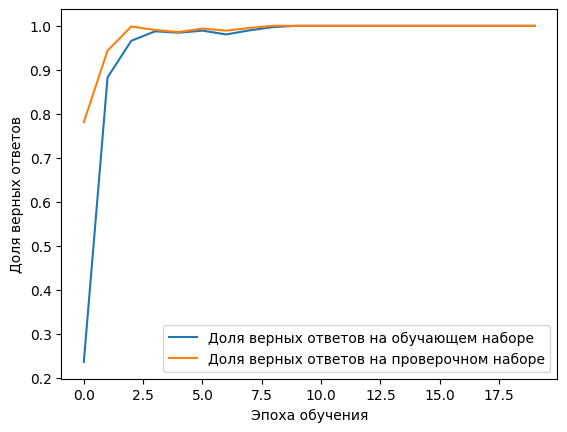

In [ ]:
# Визуализация точности на обучающей выборке
plt.plot(history_resnet.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Визуализация точности на проверочной выборке
plt.plot(history_resnet.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Отрисовка легенды
plt.legend()

# Вывод графика
plt.show()

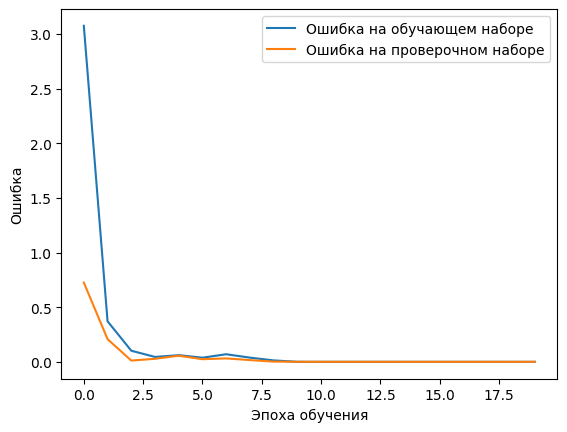

In [ ]:
# Визуализация ошибки на обучающей выборке
plt.plot(history_resnet.history['loss'],
         label='Ошибка на обучающем наборе')

# Визуализация ошибки на проверочной выборке
plt.plot(history_resnet.history['val_loss'],
         label='Ошибка на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')

plt.legend()

plt.show()

### **Проверка evaluate**

In [ ]:
scores_small = model.evaluate(x_data_test,
                              y_data_test,
                              verbose=1
                              )

print('Процент верных ответов на тестовых данных размером 80 на 60:', round(scores_small[1],4) * 100, '%')

2/2 [==============================] - 0s 30ms/step - loss: 5.9637e-04 - accuracy: 1.0000
Процент верных ответов на тестовых данных размером 80 на 60: 100.0 %


### **Проверка predict**

In [ ]:
predict_num = int(input('Введите номер интересующего пациента: '))
x = x_data_test[predict_num]
print(x.shape)

x = np.expand_dims(x, axis=0)
print(x.shape)

prediction = model.predict(x)
# print(prediction)

pred = np.argmax(prediction)
print(f'Распознан пациент: {pred}')
print(f'Настоящий пациент: {np.argmax(y_data_test[predict_num])}')

Введите номер интересующего пациента: 25
(60, 80, 3)
(1, 60, 80, 3)
1/1 [==============================] - 0s 23ms/step
Распознан пациент: 25
Настоящий пациент: 25
